### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [1]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2022-10-27 18:13:06--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.10, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  1.05MB/s    in 1.1s    

2022-10-27 18:13:08 (1.05 MB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2022-10-27 18:13:08--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.10, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.

### Reading sequences

In [2]:
%%capture
!pip install bio

In [3]:
from Bio import SeqIO, Seq
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [4]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [5]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'), 
      seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T, 
                       index=['T', 'C', 'A', 'G'], 
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [6]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181203,0.296080,0.314970,0.272901
C,0.206748,0.226955,0.233379,0.228714
A,0.256854,0.302191,0.238267,0.276767
G,0.355196,0.174773,0.213384,0.221619


### Transition probabilities

In [7]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3], 
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1
        
    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5), 
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [8]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185541,0.498016,0.316087,0.318294
C|T,0.189713,0.199146,0.180139,0.208396
A|T,0.249076,0.172641,0.221208,0.244180
G|T,0.375670,0.130197,0.282566,0.229130
T|C,0.185250,0.248514,0.269667,0.252617
C|C,0.156196,0.198164,0.244435,0.213797
A|C,0.276236,0.315008,0.244359,0.286844
G|C,0.382318,0.238314,0.241540,0.246742
T|A,0.180048,0.334056,0.307936,0.269508
C|A,0.194071,0.213889,0.193709,0.205264


TATTACTTC

In [9]:
P_seq_nc = t1['nc']['T'] * t2['nc']['A|T']*t2['nc']['T|A']*t2['nc']['T|T']*t2['nc']['A|T']*t2['nc']['C|A']*t2['nc']['T|C']*t2['nc']['T|T']*t2['nc']['C|T']
P_seq_nc

4.800850646089566e-06

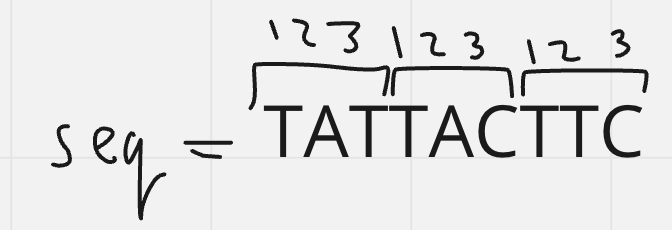

In [10]:
P_seq_cod = t1['pos1']['T']   * t2['pos2']['A|T'] * t2['pos3']['T|A'] * \
            t2['pos1']['T|T'] * t2['pos2']['A|T'] * t2['pos3']['C|A'] * \
            t2['pos1']['T|C'] * t2['pos2']['T|T'] * t2['pos3']['C|T']
P_seq_cod

9.933667623206424e-07

In [11]:
P_nc = 0.5
P_cod = 0.5
P_nc_seq = P_nc * P_seq_nc / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_nc_seq

0.8285589420792552

In [12]:
P_cod_seq = P_cod * P_seq_cod / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_cod_seq

0.1714410579207448

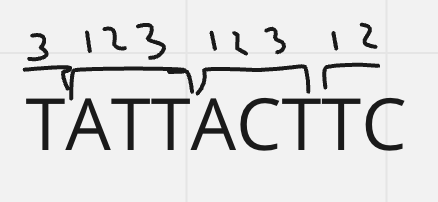

In [13]:
P_seq_cod2 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod2

4.397316710439334e-06

### Выбор участка ДНК, содержащего ген

In [113]:
candidates = [feature for feature in gb.features if (feature.location.strand==1) \
                                                and (feature.location.end-feature.location.start<3000)]
candidate = candidates[2%len(candidates)]
seq = gb.seq[candidate.location.start - 108: candidate.location.start-108+3501]

Также, посмотрим, где в выбранном участке ДНК находится этот ген.

In [114]:
print((108, candidate.location.end - candidate.location.start + 108))

(108, 1209)


## Предсказание

### Функции для расчёта вероятностей

In [115]:
def seq_cod_log_proba(seq, t1, t2, frame=1): # log(P(seq|cod_frame))
  
  if len(seq) == 0:
    print('No sequence')
    return None
  
  if frame not in [1, 2, 3]:
    print('No such frame')
    return None

  prev_nuc = seq[0]
  start_pos = 0
  
  # LOG PROB INTIALIZATION
  log_prob=np.log(t1["pos{0}".format(frame)][prev_nuc])

  for i, nuc in enumerate(seq[1:], start_pos):
    pos = "pos{0}".format(1+((i+frame)%3))
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += np.log(t2[pos][pair])
    prev_nuc = nuc
  return log_prob

def cond_probas(seq_cond_log_probas:tuple, aprior_probas:tuple=(0.25, 0.25, 0.25, 0.25)) -> tuple: # P(type[i]|seq) tuple, i=1..4
  type_log_probas=np.array([0,0,0,0])
  aprior_log_probas = np.log(aprior_probas)

  numer = seq_cond_log_probas + aprior_log_probas
  denom = np.log(np.sum(np.exp(seq_cond_log_probas + aprior_log_probas)))
  type_log_probas = numer - denom

  return np.exp(type_log_probas)

def ncod_log_proba(seq, t1, t2): # log(P(seq|ncod))
  prev_nuc=seq[0]
  log_proba = np.log(t1['nc'][prev_nuc])

  for i,nuc in enumerate(seq, 1):
    pair="{}|{}".format(nuc, prev_nuc)
    log_proba += np.log(t2['nc'][pair])
    prev_nuc = nuc
  return log_proba

def get_cod_probs(seq, t1, t2):
  prob1 = seq_cod_log_proba(seq, t1, t2, frame=1)
  prob2 = seq_cod_log_proba(seq, t1, t2, frame=2)
  prob3 = seq_cod_log_proba(seq, t1, t2, frame=3)
  probnc = ncod_log_proba(seq, t1, t2)

  return cond_probas((prob1, prob2, prob3, probnc))

def get_pos_probs(seq, t1, t2, start:int, stop:int, step:int, window:int, both_strands:bool=True):
  pos_probs = []

  for i in range(start, end, step):
    pos_probs.append(get_cod_probs(seq[i:i+window], t1, t2))

  pos_probs = np.array(pos_probs)

  if(both_strands==True):
    neg_pos_probs=[]
    for i in range(start, end, step):
      neg_pos_probs.append(get_cod_probs(seq[::-1][i:i+window], t1, t2))
    
    neg_pos_probs = np.array(neg_pos_probs)

    pos_probs = np.hstack((pos_probs, neg_pos_probs))

  return pos_probs

### Вспомогательные функции для отрисовки графика

In [116]:
def get_ORFs(seq:Seq.Seq, n_frames:int=1): # in format [start_nuc, end_nuc, frame], where the sequence is [start_nuc, end_nuc), and frame in [0,1,2]
  ORFs = []

  table=11
  for frame in range(n_frames):
    length = 3 * ((len(seq)-frame) // 3) #Multiple of three
    cnt=0

    translation = seq[frame:frame+length].translate(table)
    last_stop = translation.rfind('*')
    
    if(last_stop==-1): continue

    for pro in translation[:last_stop].split("*"):
      start = pro.find('M')
      if start!=-1 and pro[-1]: 
        ORFs.append((frame+(cnt+start)*3, frame+(cnt+len(pro)+1)*3, frame))
      cnt += len(pro)+1

  ORFs = np.array(ORFs)
  if(n_frames==1):
    ORFs = ORFs[:,:2]
  return ORFs

In [117]:
def plot_codons_marks(seq_translated, ax, start_prots:list=['M'], stop_prots:list=['*'], y_level:float=0.5, color='black'):
  starts = [i*3 for i in range(len(seq_translated)) if seq_translated[i] in start_prots]
  stops  = [i*3 for i in range(len(seq_translated)) if seq_translated[i] in stop_prots ]

  ax.plot(starts, np.ones_like(starts)*y_level, '.', color=color, marker=2)
  ax.plot(stops , np.ones_like(stops )*y_level, '.', color=color, marker=3)

def plot_orfs(ORFs, ax, y_level:float=0.5, color='black'):
  for orf in ORFs:
    ax.plot(orf, np.ones_like(orf)*y_level, '-', color=color)

def plot_genes_prediction(x_data, p_data, ORFs, frame, ax, treshold:float=0.5, y_level:float=0., color='black', linewidth=5.0):
  for orf in ORFs:
    ind1, ind2 = np.searchsorted(x_data, orf[0]+frame), np.searchsorted(x_data, orf[1]+frame)
    if(ind1==ind2): continue
    p_value = p_data[ind1:ind2+1].mean()
    if(p_value<treshold): continue

    ax.plot(orf, np.ones_like(orf)*y_level, '-', color=color, linewidth=linewidth)

In [ ]:
def plot_graph(data, start, end, step, drop_ncods:bool=True, both_strands:bool=True):
  if(drop_ncods==True):
    if(both_strands==True):
      data = data[:, [0,1,2,4,5,6]]
    else:
      data = data[:, :-1]

  fig, ax = plt.subplots(data.shape[1], 1, figsize=(15, 5*data.shape[1]))

  x = list(range(start, end, step))

  for frame in range(len(ax)):
    ax[frame].plot(x, data[:,frame])
    cur_seq = seq[frame:(len(seq)-frame)//3*3+frame]
    seq_tr = cur_seq.translate()

    plot_codons_marks(seq_tr, ax[frame])

    ORFs = get_ORFs(seq, n_frames=1)
    plot_orfs(ORFs, ax[frame])

    plot_genes_prediction(x, data[:,frame], ORFs, frame, ax[frame])

    ax[frame].set_title(f'Codon position {(frame+1) if frame<3 else (2-frame)}')
    
  plt.plot()

### График

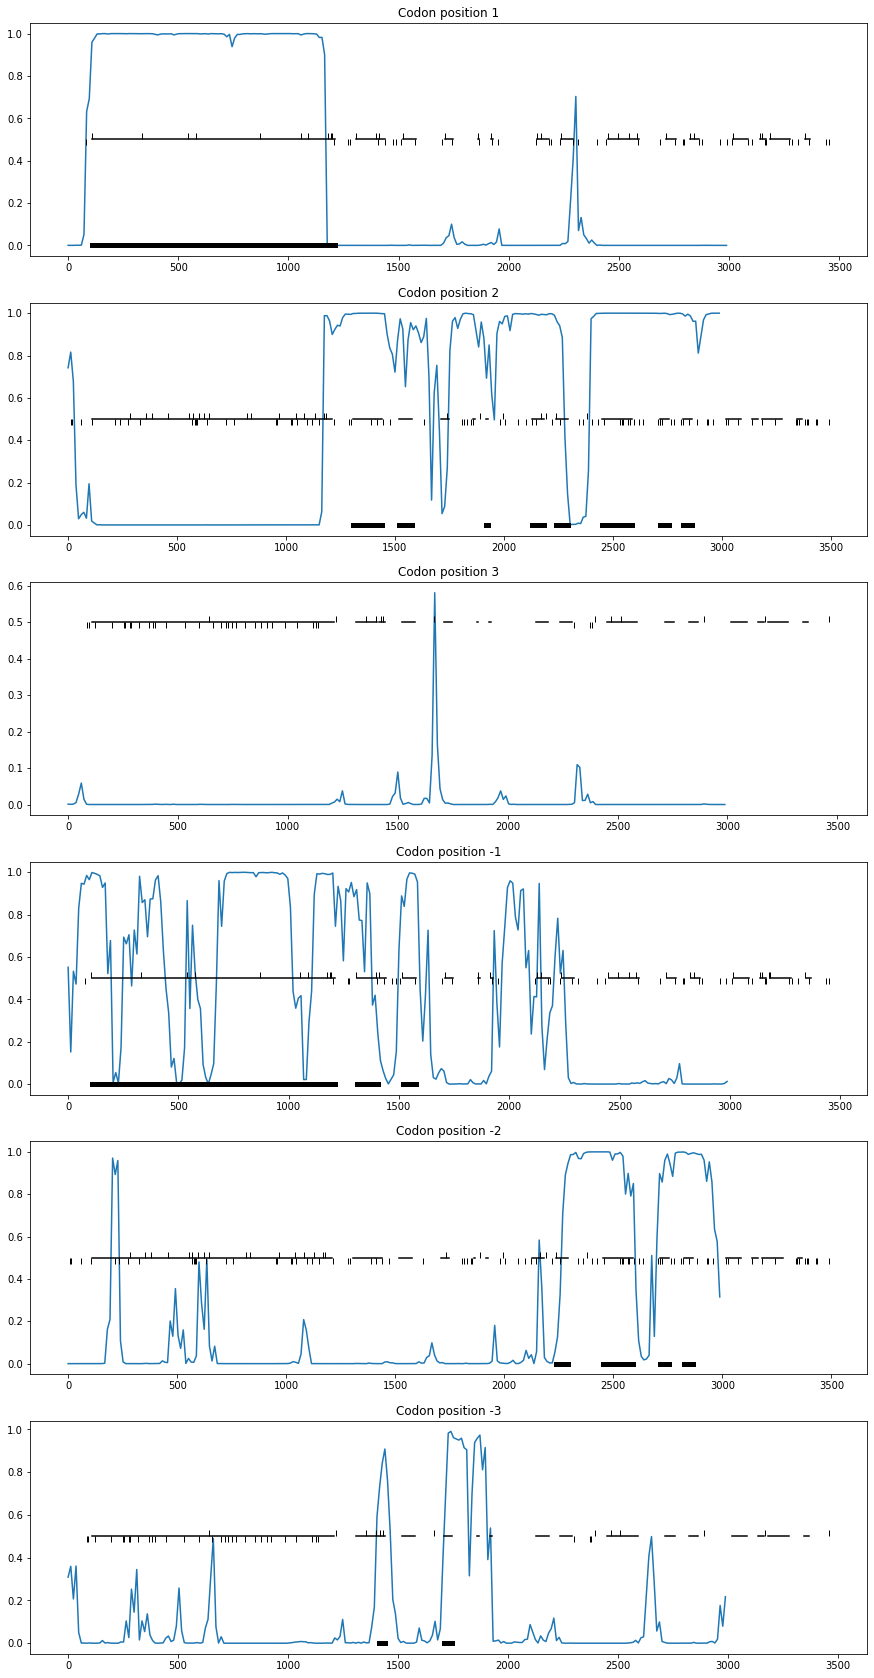

In [118]:
start = 0
end = 3000
step = 12
window = 96
pos_probs = get_pos_probs(seq, t1, t2, start, end, step, window)

plot_graph(pos_probs, start, end, step)